
## Optimizing SQLite performance using MLOS Optimizer

### Overview:

#### > Improve the performance of SQLite by tuning:
    - external parameters
        - like pagesize, cachesize, shrinkmemory 
    - internal parameter
        - like dirty-page-cache-ratio
        
#### > MLOS shared-memory is not applicable in this example

#### > Performance data with Googlebenchmark + PAPI

#### > Using MLOS optimizer with a python loop: <br> <br>


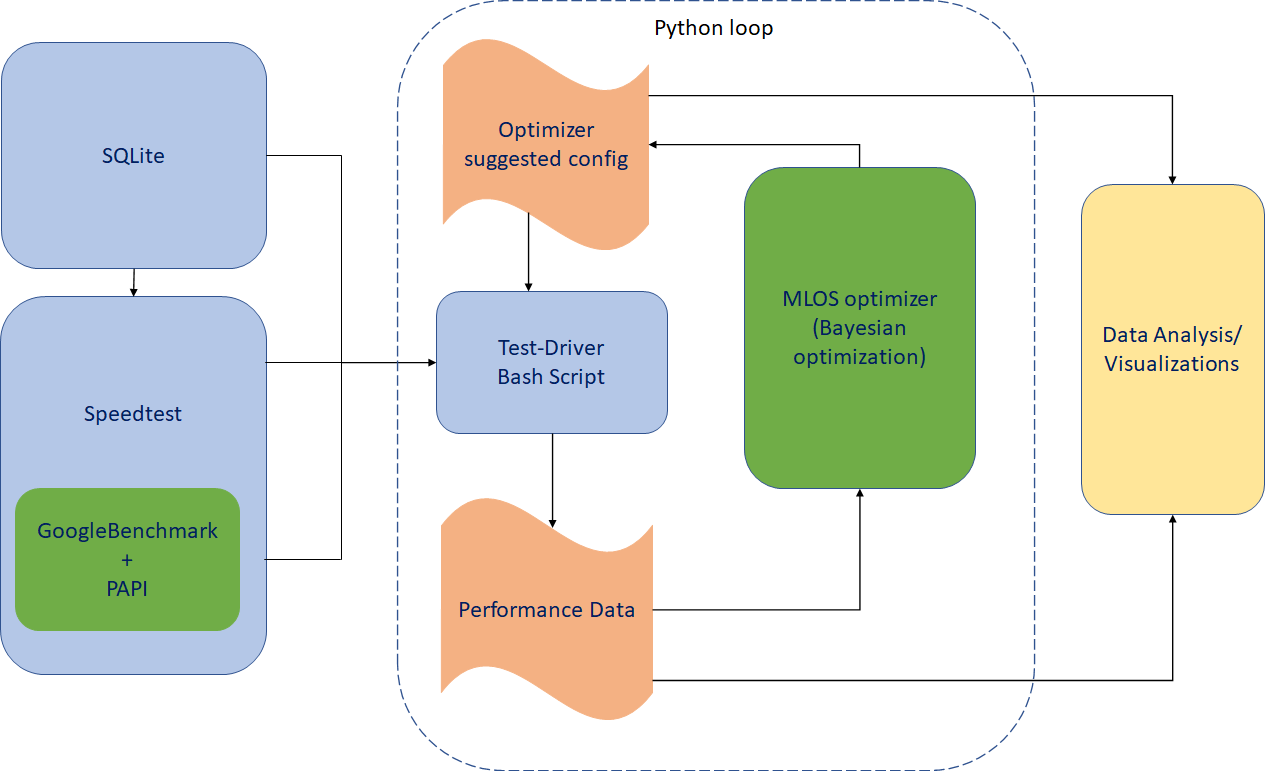


#### More Details Follow Here:
The page-cache configuration parameter in SQLite sets the purgeable ratio to 90% which means page-cache mechanism in SQLite will begin purging dirty pages from cache when 90% of the cache is dirty instead of waiting until it is 100% dirty. 
SQLite claims that this improves performance in some circumstances by effectively reserving 10% of the configured page-cache for frequently reused read-only pages.<br>
The goal of this notebook is to optimize internal tunable as "dirty-page-cache-ratio" alongwith some external exposed tunables that can impact the overall execution of the workload. <br>

We're using MLOS optimizer for this problem which is using Bayesian Optimizer, that consists of the following loop:<br>
1) Get suggested config from optimizer, <br>
2) Apply suggested configs to compile and run SQLite code, <br>
3) Execute a fixed workload(Database creation and bunch of SQL operations), <br>
4) Collect the performance metrics from page-cache, <br>
5) Register an observation with the optimizer.


NOTE: SQlite is written in C and there are compile time decisions we need to make so MLOS-sharedMemory is not applicable here. Because currently MLOS doesn't have C support. So we opted of doing python loop here to use MLOS-optimizer.

### Existing speedtest program
##### Infra to run speedtest:
1) SQLite amalgamation source files – sqlite3.h and sqlite3.c <br>
2) Test program – speedtest1.c and speedtest1.h <br>
3) Driver bash script -> compiles the sqlite code with compile-time options and run it with some PRAGMA settings.  <br>

###### Workload:- Below are the SQL operations that run on SQLite

"Query1: INSERTs into table with no index", <br>
"Query2: ordered INSERTS with one index/PK", <br>
"Query3: unordered INSERTS with one index/PK", <br>
"Query4: SELECTS, numeric BETWEEN, unindexed", <br>
"Query5: SELECTS, LIKE, unindexed", <br>
"Query6: SELECTS w/ORDER BY, unindexed", <br>
"Query7: SELECTS w/ORDER BY and LIMIT, unindexed", <br>
"Query8: CREATE INDEX five times", <br>
"Query9: SELECTS, numeric BETWEEN, indexed", <br>
"Query10: SELECTS, numeric BETWEEN, PK", <br>
"Query11: SELECTS, text BETWEEN, indexed", <br>
"Query12: INSERTS with three indexes", <br>
"Query13: DELETE and REFILL one table", <br>
"Query14: VACUUM", <br>
"Query15: ALTER TABLE ADD COLUMN, and query", <br>
"Query16: UPDATES, numeric BETWEEN, indexed", <br>
"Query17: UPDATES of individual rows", <br>
"Query18: One big UPDATE of the whole", <br>
"Query19: Query added column after filling", <br>
"Query20: DELETEs, numeric BETWEEN, indexed", <br>
"Query21: DELETEs of individual rows", <br>
"Query22: Refilling using REPLACE", <br>
"Query23: Refiling using (b&1)==(a&1)", <br>
"Query24: four-ways joins", <br>
"Query25: subquery in result set", <br>
"Query26: REPLACE ops on an IPK", <br>
"Query27: SELECTS on an IPK", <br>
"Query28: REPLACE on TEXT PK", <br>
"Query29: SELECTS on a TEXT PK", <br>
"Query30: SELECT DISTINCT", <br>
"Query31: PRAGMA integrity_check", <br>
"Query32: ANALYZE" <br>

### Performance Measurement
##### Googlebenchmark + PAPI:
This is an intergeration to write microbenchmarks with googlebenchmark library and collect hardware/os counters using PAPI library. This integrated library is easy to stitch with C/C++ applications and hence we used it in SQLite speedtest program to collect performance measurements.
##### SQLite speedtest wiring with  Googlebenchmark + PAPI:
Existing speedtest code where changes for GB+PAPI are needed:

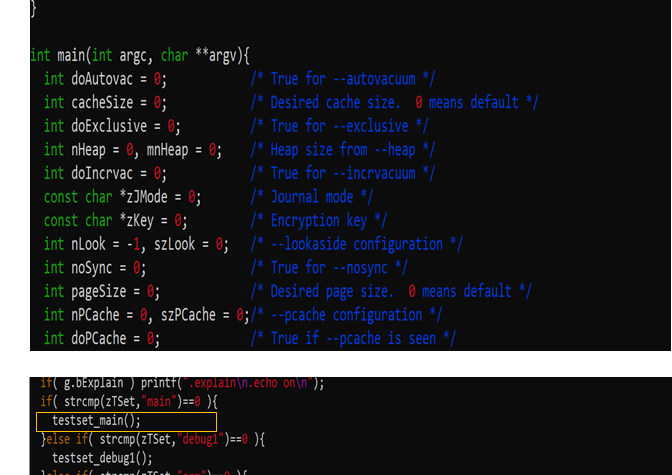

Below are the few changes made to the speedtest program:

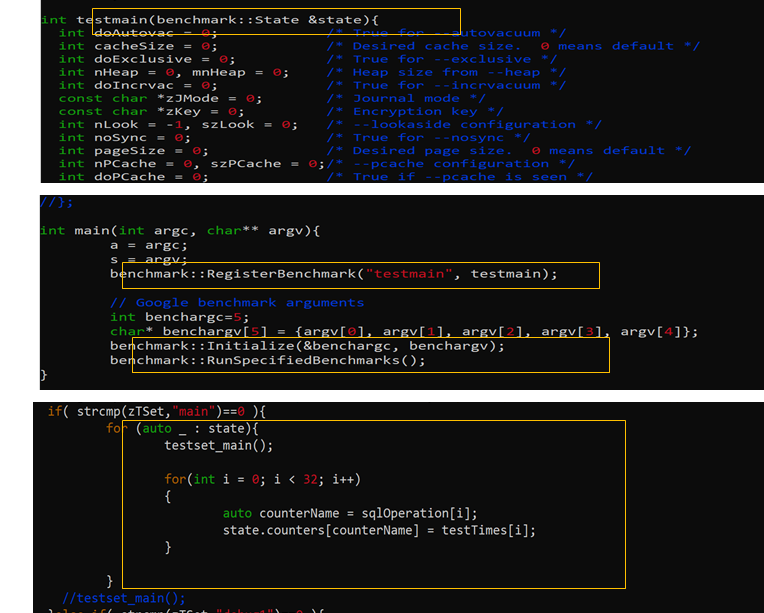

#### Output from Googlebenchmark:
Available formats -> text, csv, json <br>
Below output is in json format:
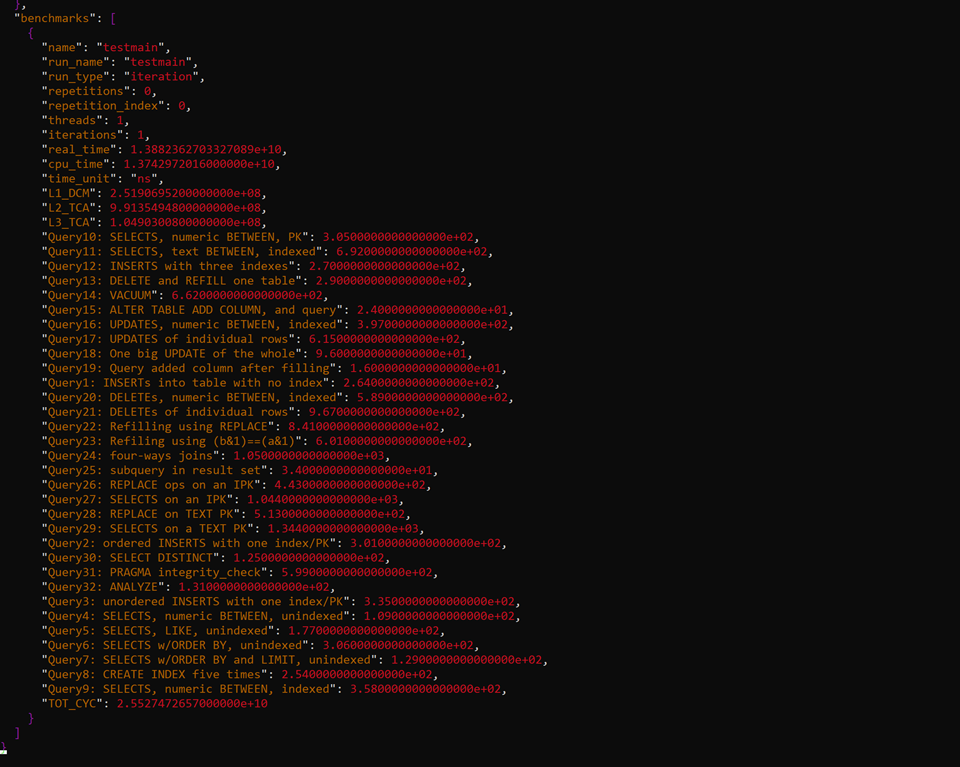

### Begining of the optimization

In [1]:
# Import the required classes and tools
import subprocess
import pandas as pd
import json
import csv
import os, fnmatch
import matplotlib.pyplot as plt
import numpy as np
from shutil import copyfile
from datetime import datetime


#### Directory inputs for output files

In [2]:
# set the benchmark output directory
BENCH_SUMMARY_DIR = 'bayesian-bench-input15-memUsage-mincputime-summary-files_take4/'

# set the benchmark error directory
BENCH_ERROR_DIR = BENCH_SUMMARY_DIR+"error-files"

# set optimizer results csv
OPTIMIZER_DATA_CSV = BENCH_SUMMARY_DIR+"optimizer_data.csv"

In [4]:
# Data pre-processing steps for performance-data 
#from optimization_data import set_header, getMetrics
FILE_HEADER = []


### About SQLite Tunables

#### List of run-time parameters: 
| External tunable | Argument/s   | Description   | 
|:-|:-|:-|
|  autovacuum |       | Enable AUTOVACUUM mode |
|  cachesize |N       | Set the cache size to N (number-of-pages) |
|  exclusive |         | Enable locking_mode=EXCLUSIVE |
|  explain |           | Like --sqlonly but with added EXPLAIN keywords |
|  heap | SZ MIN       | Memory allocator uses SZ bytes & min allocation MIN |
|  incrvacuum |        | Enable incremenatal vacuum mode |
|  journal | M         | Set the journal_mode to M |
|  key | KEY           | Set the encryption key to KEY |
|  lookaside | N SZ    | Configure lookaside for N slots of SZ bytes each |
|  mmap | SZ           | MMAP the first SZ bytes of the database file |
|  multithread |       | Set multithreaded mode |
|  nomemstat |         | Disable memory statistics |
|  nosync |            | Set PRAGMA synchronous=OFF |
|  notnull |           | Add NOT NULL constraints to table columns |
|  pagesize | N        | Set the page size to N |
|  pcache | N SZ       | Configure N pages of pagecache each of size SZ bytes |
|  primarykey |        | Use PRIMARY KEY instead of UNIQUE where appropriate |
|  repeat | N          | Repeat each SELECT N times (default: 1) |
|  reprepare |         | Reprepare each statement upon every invocation |
|  serialized |        | Set serialized threading mode |
|  singlethread |      | Set single-threaded mode - disables all mutexing |
|  sqlonly |           | No -op.  Only show the SQL that would have been run |
|  shrink-memory |     | Invoke sqlite3_db_release_memory() frequently |
|  size | N            | Relative test size.  Default=100 |
|  stats |             | Show statistics at the end |
|  temp | N            | N from 0 to 9.  0: no temp table. 9: all temp tables |
|  testset | T         | Run test-set T (main, cte, rtree, orm, fp, debug) |
|  trace |             | Turn on SQL tracing |
|  threads | N         | Use up to N threads for sorting |
|  utf16be |           | Set text encoding to UTF-16BE |
|  utf16le |           | Set text encoding to UTF-16LE |
|  verify |            | Run additional verification steps |
|  without-rowid |     | Use WITHOUT ROWID where appropriate |


#### List of compile time parameters:
SQLite compile-time options          -> https://www.sqlite.org/compile.html

#### Internal tunable paramater 
| Internal tunable | Argument/s   | Description   | 
|:-|:-|:-|
|  pageCache_Dirty_percent |   N    | purgeable percentage, default is 90 |

### Default parameters to run the workload.

In [4]:
# Default compile-time config options to SQLite 
CC_OPTS = "-DSQLITE_ENABLE_RTREE -DSQLITE_ENABLE_MEMSYS5" 

# scale factor for test size. 
SIZE = "100" 


### Optimum from CPU-time objective

- To achieve multi objective
    - Obtained this from previous optimization for overall CPU_TIME as obective using MLOS optimizer

In [21]:
# This is to show the performance gain by ~3x faster  
df_cpuTime = pd.read_csv('bayesian-bench-input15-cputime-summary-files_take1/optimizer_data.csv')
print("Optimum from MLOS optimization for cpu_time as objective: ", df_cpuTime['func_val'].min(), "sec")


Optimum from MLOS optimization for cpu_time as objective:  4.70919316 sec


### Defining Objective Function

In [6]:
# Objective function-value. This function value can be anything from performance metrics we're collecting. 
# To see other metrics, run below column
FUNC_VAL = 'memoryUsage(KB)' # Total Cache Access - L2 -> 1536KB

# Objective function definition
eps = 1.000
cputime_optimum = 4.709
large_number = 200000.000

def get_objective(totmem, cputime):
    if cputime > (cputime_optimum + eps):
        return large_number 
    else:
        return totmem

### Defining Experiment

Here is what we are defining the complete experiment that will pass the config parameters: compile-time parameters and run-time parameters. This will compile the sqlite source code and run the workload with passed run-time parameters. 

In [7]:
# Run SQLite experiment
def runSqliteExperiment(pageCache_Dirty_percent, heapsize, heapmin, cachesize, 
                        pagesize, shrinkmemory, reprepare, 
                        exclusive, vacuum, nomemstat, 
                        notnull, primarykey, withoutrowid):
    x = pageCache_Dirty_percent
    benchFN = "{0}%.json".format(x)
    pctunable = str(x/10) # page cache tunable
    expScript = "bench-run-speed-test.sh"
    
    heapmin = 2**heapmin 
    pagesize = 2**pagesize
    
    if (vacuum == 'autoenable'):
        autovacuum = 'enable'
        incrvacuum = 'disable'
    elif (vacuum == 'increnable'):
        autovacuum = 'disable'
        incrvacuum = 'enable'
    else:
        autovacuum = 'disable'
        incrvacuum = 'disable'
    
    res = subprocess.check_output(["sh", expScript, benchFN, BENCH_SUMMARY_DIR,
                                   CC_OPTS,
                                   "--heap", str(heapsize), str(heapmin),
                                   "--cachesize", str(cachesize),
                                   "--pagesize", str(pagesize),
                                   "--size", str(SIZE),
                                   "--pctunable", str(pctunable),
                                   "--shrink-memory", str(shrinkmemory), 
                                   "--reprepare", str(reprepare),
                                   "--exclusive", str(exclusive),
                                   "--autovacuum", str(autovacuum),
                                   "--incrvacuum", str(incrvacuum), 
                                   "--nomemstat", str(nomemstat),
                                   "--notnull", str(notnull), 
                                   "--primarykey", str(primarykey), 
                                   "--without-rowid", str(withoutrowid)])
    if not FILE_HEADER:
        set_header()
        
    # get data in dict and dataframe
    filename = "{0}-{1}".format("bench-summary", benchFN)
    metrics, df = getMetrics(filename, x)
    totmem = df[FUNC_VAL].values.tolist()[0]
    cputime = df['cpu_time'].values.tolist()[0]
    return df,get_objective(totmem, cputime)
    #return df, df['cpu_time'].values.tolist()[0]

### Defining input parameter space with MLOS optimizer
The optimization problem is constructed using this parameter space as the input to optimize, and defines a single continuous objective, which is 'FUNC_VAL'.

In [8]:
from mlos.Optimizers.OptimizationProblem import OptimizationProblem, Objective
from mlos.Optimizers.BayesianOptimizer import BayesianOptimizer
from mlos.Spaces import SimpleHypergrid, ContinuousDimension, CategoricalDimension, DiscreteDimension

# single continuous input dimension between 0 and 1
input_space = SimpleHypergrid(
    name="input",
    dimensions=[
        ContinuousDimension(name="pageCache_Dirty_percent", min=40, max=100), 
        ContinuousDimension(name="heapsize", min=10000000, max=1000000000), 
        DiscreteDimension(name="heapmin", min=6, max=10), # 64 to 1024
        ContinuousDimension(name="cachesize", min=500, max=10000),
        DiscreteDimension(name="pagesize", min=9, max=16), # 512 to 65536
        CategoricalDimension(name="shrinkmemory", values=['enable', 'disable']),
        CategoricalDimension(name="reprepare", values=['enable', 'disable']),
        CategoricalDimension(name="exclusive", values=['enable', 'disable']),
        CategoricalDimension(name="vacuum", values=['autoenable', 'increnable', 'disable']),
        #CategoricalDimension(name="incrvacuum", values=['enable', 'disable']),
        CategoricalDimension(name="nomemstat", values=['enable', 'disable']),
        CategoricalDimension(name="notnull", values=['enable', 'disable']),
        CategoricalDimension(name="primarykey", values=['enable', 'disable']),
        CategoricalDimension(name="withoutrowid", values=['enable', 'disable'])
    ]
)
# define output space, we might not know the exact ranges
output_space = SimpleHypergrid(name="objective",
                               dimensions=[ContinuousDimension(name="function_value", min=15000, max=110000)])

# define optimization problem with input and output space and objective
optimization_problem = OptimizationProblem(
    parameter_space=input_space,
    objective_space=output_space,
    # we want to minimize the function
    objectives=[Objective(name="function_value", minimize=True)]
)

### Set the configurations for MLOS optimizer

In [9]:
from mlos.Optimizers.BayesianOptimizerConfigStore import bayesian_optimizer_config_store
from mlos.Optimizers.BayesianOptimizerFactory import BayesianOptimizerFactory
from mlos.Spaces import Point

# configure the optimizer, start from the default configuration
optimizer_config = bayesian_optimizer_config_store.default
# set the fraction of randomly sampled configuration to 10% of suggestions
optimizer_config.experiment_designer_config_fraction_random_suggestions = .1
# optimizer_config.experiment_designer_config.fraction_random_suggestions = 1
# configure the random forest surrogate model
random_forest_config = optimizer_config.homogeneous_random_forest_regression_model_config
# refit the model after each observation
random_forest_config.decision_tree_regression_model_config.n_new_samples_before_refit = 1
# Use the best split in trees (not random as in extremely randomized trees)
random_forest_config.decision_tree_regression_model_config.splitter = 'best'
# right now we're sampling without replacement so we need to subsample
# to make the trees different when using the 'best' splitter
random_forest_config.samples_fraction_per_estimator = .9
# Use 10 trees in the random forest (usually more are better, 10 makes it run pretty quickly)
random_forest_config.n_estimators = 100
# Set multiplier for the confidence bound
optimizer_config.experiment_designer_config.confidence_bound_utility_function_config.alpha = 0.1

optimizer_factory = BayesianOptimizerFactory()
optimizer = optimizer_factory.create_local_optimizer(
    optimization_problem=optimization_problem,
    optimizer_config=optimizer_config
)

12/07/2020 06:57:50 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 100,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 0.9,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_

### Define a function to run the optimizer
#### Running optimizer will perform below steps: <br>
1) Get suggestions from optimizer for configs in input space <br>
2) Run the sqlite experiment with suggested values from optimizer<br>
3) Save the inputs(config values) and outputs(performance metrics) in csv format for further analysis.<br>


In [10]:
def run_optimization(optimizer):
    print("Start: ", datetime.now().time())
    # suggest new value from optimizer
    suggested_value = optimizer.suggest()
    input_values_df = suggested_value.to_dataframe()
    # suggested value are dictionary-like, keys are input space parameter names
    # evaluate target function
    print("Suggestions done: ", datetime.now().time())
    metrics_df, target_value = runSqliteExperiment(suggested_value['pageCache_Dirty_percent'], suggested_value['heapsize'], 
                                                   suggested_value['heapmin'], suggested_value['cachesize'], 
                                                   suggested_value['pagesize'], suggested_value['shrinkmemory'],
                                                   suggested_value['reprepare'], suggested_value['exclusive'], 
                                                   suggested_value['vacuum'], suggested_value['nomemstat'],
                                                   suggested_value['notnull'], suggested_value['primarykey'], 
                                                   suggested_value['withoutrowid']
                                      )
    print(suggested_value, target_value)
    
    # build dataframes to 
    if (target_value != 0):
        target_values_df = pd.DataFrame({'function_value': [target_value]})
        optimizer.register(input_values_df, target_values_df)
        res = pd.concat([input_values_df, target_values_df, metrics_df], axis=1)
        res.to_csv(OPTIMIZER_DATA_CSV, mode='a', header=True)
        
    print("\n")
    print("End: ", datetime.now().time())
    

# run for some iterations
n_iterations = 1
for i in range(n_iterations):
    run_optimization(optimizer)

Start:  22:57:52.385730
Suggestions done:  22:57:52.391878
{
  "pageCache_Dirty_percent": 94.27686604326381,
  "heapsize": 537582137.1572487,
  "heapmin": 8,
  "cachesize": 7275.405964739481,
  "pagesize": 11,
  "shrinkmemory": "disable",
  "reprepare": "enable",
  "exclusive": "enable",
  "vacuum": "disable",
  "nomemstat": "disable",
  "notnull": "disable",
  "primarykey": "disable",
  "withoutrowid": "enable"
} 200000.0


End:  22:58:32.390143


### Run iterations on optimizer run

In [11]:
# # First round
# n_iterations = 5000
# for i in range(n_iterations):
#     print("({0}/{1})".format(i, n_iterations))
#     run_optimization(optimizer)

### Previous Run of the same optimization

- Reading the optimizer data from previous run
- registring it with the MLOS optimizer

In [12]:
df = pd.read_csv("bayesian-bench-input15-memUsage-mincputime-summary-files_take3/optimizer_data.csv")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
input_values_df1 = df.iloc[:, :13]
target_values_df1 = df.iloc[:, 13:14]
optimizer.register(input_values_df1, target_values_df1)

### Checking the optimum

In [13]:
optimizer.optimum()

({
   "pageCache_Dirty_percent": 97.02132275925324,
   "heapsize": 51336830.72195765,
   "heapmin": 9,
   "cachesize": 544.3528498660329,
   "pagesize": 13,
   "shrinkmemory": "disable",
   "reprepare": "disable",
   "exclusive": "enable",
   "vacuum": "disable",
   "nomemstat": "enable",
   "notnull": "disable",
   "primarykey": "enable",
   "withoutrowid": "enable"
 },
 {
   "function_value": 22920
 })

### Interactive plots 

In [14]:
from interactive_plot import show_plot

In [15]:
show_plot()

Loading BokehJS ...

### Interesting data trends

Target looks like regression
Showing only top 10 of 44 continuous features


/home/negodwal/.local/lib/python3.7/site-packages/dabl/plot/utils.py:630: UserWarning: Dropped 2 outliers in column Query21: DELETEs of individual rows.
  int(dropped), series.name), UserWarning)
/home/negodwal/.local/lib/python3.7/site-packages/dabl/plot/utils.py:630: UserWarning: Dropped 5 outliers in column Query24: four-ways joins.
  int(dropped), series.name), UserWarning)


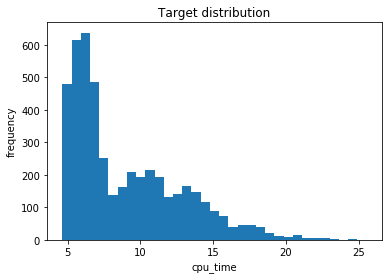

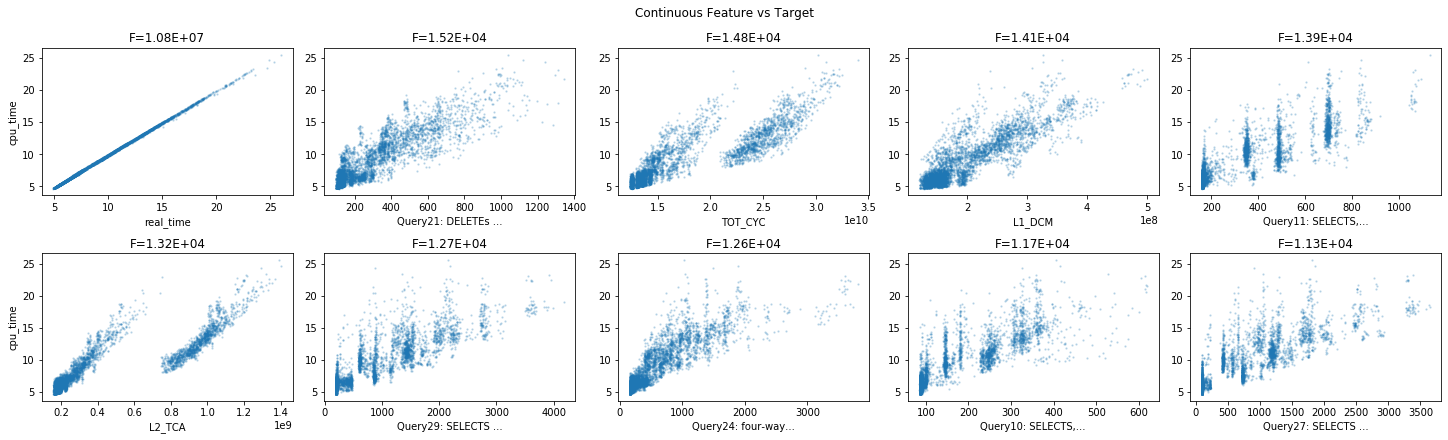

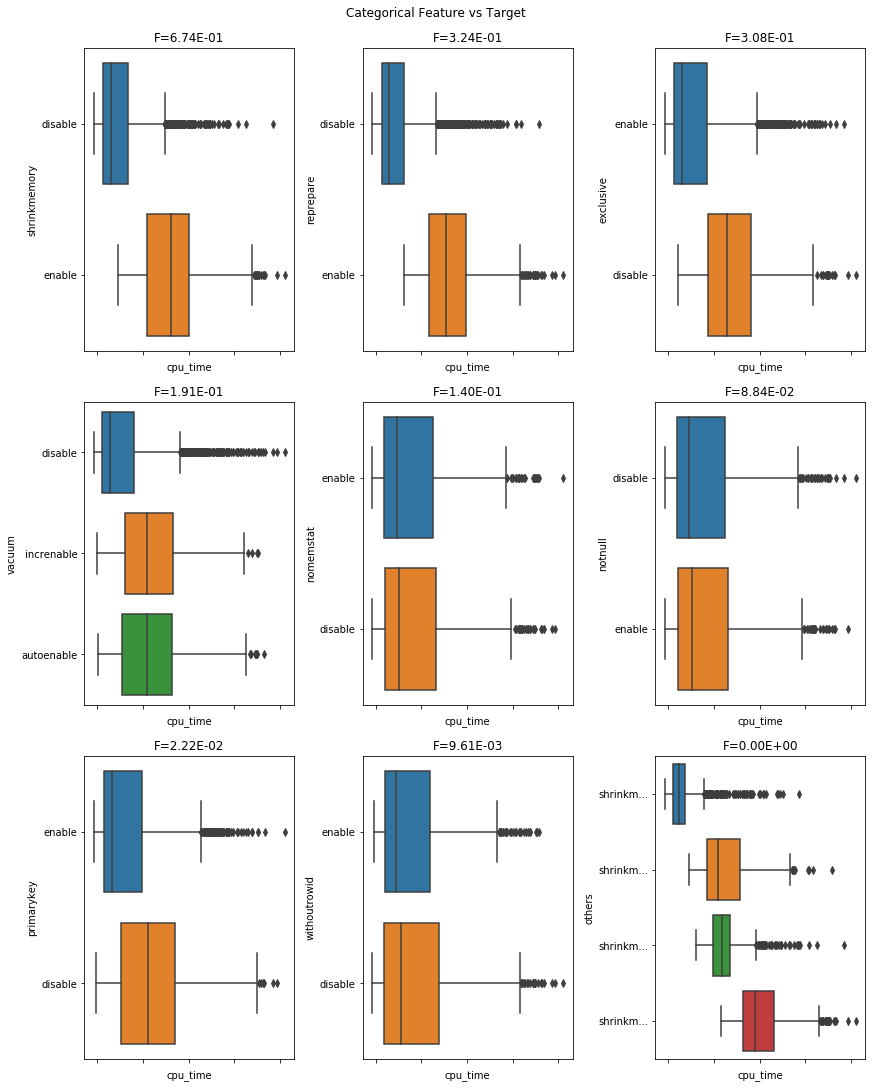

In [49]:
import dabl
dabl.plot(df, target_col='cpu_time')

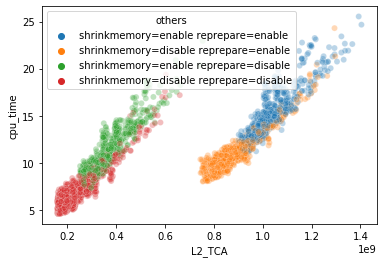

In [46]:
import seaborn as sns
df['others'] = "shrinkmemory=" + df.shrinkmemory.astype(str) + " reprepare=" + df.reprepare.astype(str)
sns.scatterplot(data=df, x="L2_TCA", y='cpu_time', hue='others', alpha=0.3)


In [39]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
filtered = df[df.shrinkmemory == 'disable']
filtered = filtered[filtered.reprepare == 'disable']
def preprocess(x):
    if x == "enable" or x == "autoenable":
        return 1
    if x == "increnable":
        return 2
    if x == "disable":
        return 0
    return x
filtered = filtered.applymap(preprocess)

In [40]:
# bla is filtered data and containes shrinkmemory=disable and reprepare=disable
X = filtered.iloc[:, :13]
y = filtered['memoryUsage(KB)']

### Partial Dependence Plots

In [41]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor().fit(X, y)

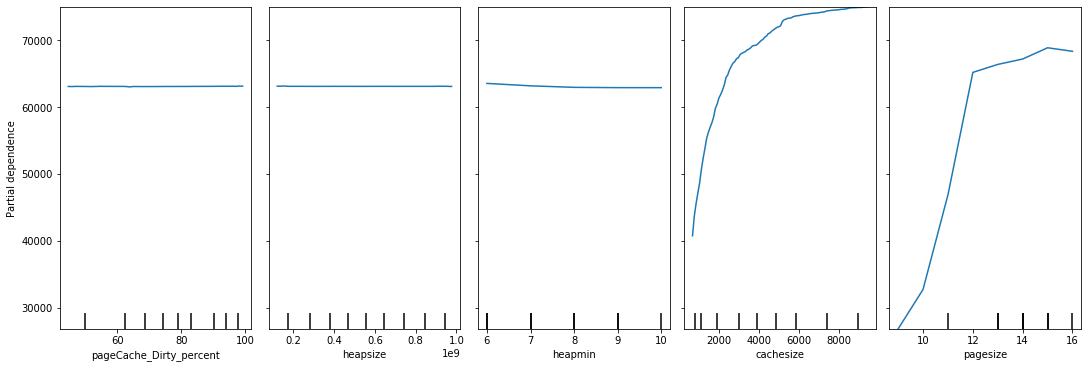

In [42]:
from sklearn.inspection import plot_partial_dependence
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5), constrained_layout=True)
pdplot = plot_partial_dependence(rf, X, features=X.columns[:5], n_cols=5, ax=plt.gca())

In [43]:
y = filtered['cpu_time']

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor().fit(X, y)

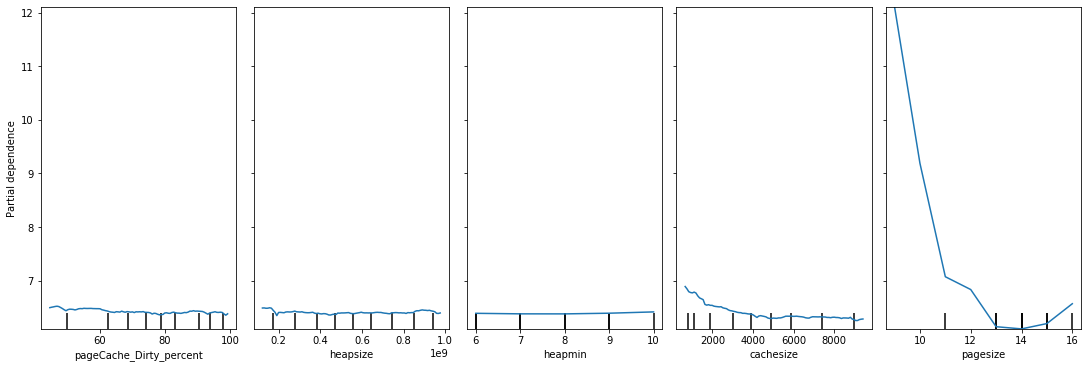

In [44]:
plt.figure(figsize=(15, 5), constrained_layout=True)
pdplot = plot_partial_dependence(rf, X, features=X.columns[:5], n_cols=5, ax=plt.gca())